In [1]:
# Run if you are on Google Colab to install the Python bindings
!bash compile.sh

running build_ext
gcc -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -I/Users/wonjunlee/miniconda3/envs/cv/include -arch x86_64 -I/Users/wonjunlee/miniconda3/envs/cv/include -arch x86_64 -I/Users/wonjunlee/miniconda3/envs/cv/include/python3.6m -c flagcheck.cpp -o flagcheck.o -std=c++17
building 'screening' extension
gcc -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -I/Users/wonjunlee/miniconda3/envs/cv/include -arch x86_64 -I/Users/wonjunlee/miniconda3/envs/cv/include -arch x86_64 -DVERSION_INFO=0.0.1 -I/Users/wonjunlee/miniconda3/envs/cv/lib/python3.6/site-packages/pybind11/include -I/Users/wonjunlee/miniconda3/envs/cv/include/python3.6m -c src/main.cpp -o build/temp.macosx-10.9-x86_64-3.6/src/main.o -std=c++17 -mmacosx-version-min=10.14 -fvisibility=hidden -g0 -stdlib=libc++
g++ -bundle -undefined dynamic_lookup -L/Users/wonjunlee/miniconda3/envs/cv/lib -arch x86_64 -L/Use

In [2]:
import argparse
import os
import numpy as np
from scipy.fftpack import dctn, idctn
import math
import sys
import copy
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch

cuda = True if torch.cuda.is_available() else False
os.makedirs("images", exist_ok=True)

# Poisson solver with Neumann boundary conditions

Solving the following problem on the domain $\Omega= [0,1]^2$,
$$- \Delta u = f $$
$$ \partial_n u = g $$
where
$$ f(x,y) = \cos(\pi x + C) \cos(\pi y + C) $$
$$ u(x,y) = \frac{1}{(2\pi)^2}\cos(\pi x + C) \cos(\pi y + C) $$
$$ g_x(x,y) = - \frac{1}{4\pi} \sin(\pi x + C)\cos(\pi y + C) $$
$$ g_y(x,y) = - \frac{1}{4\pi} \cos(\pi x + C)\sin(\pi y + C) $$

Text(0.5, 1.0, 'initial density')

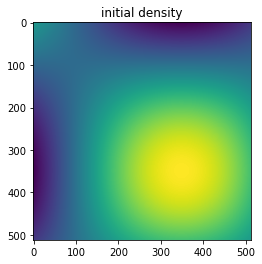

In [3]:
# Poisson Solver
# Solving -\Delta u = f with a boundary condition \partial_n u = g (Neummann)
n = 512
f = np.zeros((n,n))
u = np.zeros_like(f)
X, Y = np.meshgrid(np.linspace(0.5/n,1-0.5/n,n), np.linspace(0.5/n,1-0.5/n,n))
yMax = 5
X*=yMax
Y*=yMax
C = 1
f = np.cos(X/yMax * np.pi + C) * np.cos(Y/yMax * np.pi + C)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(f)
ax.set_title("initial density")

In [4]:
# Initialize Fourier kernel
def initialize_kernel(n1, n2, dy):
    xx, yy = np.meshgrid(np.linspace(0,np.pi,n1,False), np.linspace(0,np.pi,n2,False))
    # kernel = 2*n1*n1*(1-np.cos(xx)) + 2*n2*n2*(1-np.cos(yy))
    kernel = 2*(1-np.cos(xx))/(dy*dy) + 2*(1-np.cos(yy))/(dy*dy)
    kernel[0,0] = 1     # to avoid dividing by zero
    return kernel

# 2d DCT
def dct2(a):
    return dctn(a, norm='ortho')

# 2d IDCT
def idct2(a):
    return idctn(a, norm='ortho')

# Solving Poisson
#   - Δ u = f
#   output: u = (-Δ)⁻¹ f
def solve_poisson(u, f, kernel):
    n = u.shape[0]
    u[:] = 0
    workspace = np.copy(f)
    workspace = dct2(workspace) / kernel
    workspace[0,0] = 0
    u += idct2(workspace)

def solve_poisson_bdry(u, f, bdry, kernel):
    gx0, gx1, gy0, gy1 = bdry
    n = u.shape[0]
    u[:] = 0
    workspace = np.copy(f)
    workspace[0,:]   -= gy0 * n
    workspace[n-1,:] += gy1 * n
    workspace[:,0]   -= gx0 * n
    workspace[:,n-1] += gx1 * n
    workspace = dct2(workspace) / kernel
    workspace[0,0] = 0
    u += idct2(workspace)

In [5]:
x0 = 0
x1 = 1
y0 = 0
y1 = 1
xx = np.linspace(0.5/n,1-0.5/n,n)
gy0 = -1.0/(2.0*np.pi) * np.cos(np.pi * xx + C) * np.sin(np.pi * y0 +  C)
gy1 = -1.0/(2.0*np.pi) * np.cos(np.pi * xx + C) * np.sin(np.pi * y1 +  C)
gx0 = -1.0/(2.0*np.pi) * np.sin(np.pi * x0 + C) * np.cos(np.pi * xx +  C)
gx1 = -1.0/(2.0*np.pi) * np.sin(np.pi * x1 + C) * np.cos(np.pi * xx +  C)


Text(0.5, 1.0, 'error: 3.822657908006847e-12')

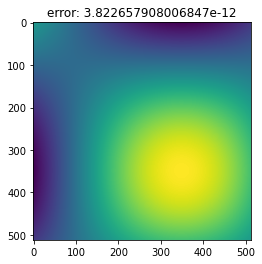

In [6]:
# Testing poisson solver
kernel = initialize_kernel(n, n, 1.0/n*yMax)
solve_poisson_bdry(u,f,[gx0,gx1,gy0,gy1],kernel)
plt.imshow(u)
plt.title(f"error: {np.mean( (u - u.mean() - (f - f.mean()) * (0.5/(np.pi/yMax)**2))**2 )}")

# c-transform

$$ \phi^c(x) = \inf_y c(x,y) + \phi(y) $$

$$ c(x,y) = \frac12 |y|^2$$

$$ \phi^c(x) = \inf_y \frac12 |y|^2 + \phi(y) $$

In [7]:
# performing c transform
# output: modified psi
def c_transform(psi: torch.tensor, phi: torch.tensor, cost: torch.tensor):
  n = phi.shape[0]
  psi[:] = torch.min(cost + phi.view((1,n*n)), dim=1).values.view((n,n))

def c_transform_forward(phi: torch.tensor, psi: torch.tensor, cost: torch.tensor):
  n = phi.shape[0]
  phi[:] = torch.max(- cost + psi.view((n*n,1)), dim=0).values.view((n,n))

# push forward
def approx_push(nu: torch.tensor, psi: torch.tensor, phi: torch.tensor, cost: torch.tensor, epsilon: float, dx: float, dy: float, yMax: float):
  mat   = torch.exp((psi.view((n*n,1)) - phi.view((1,n*n)) - cost) / epsilon) # mat = (n*n, n*n) matrix
  mat  /= torch.sum(mat, dim=1).view((n*n,1)) * (dy*dy)
  nu[:] = torch.sum(mat, dim=0).view((n,n)) * (dx*dx)

size of cost:  (2500, 2500)
b: (50, 50) (50, 50) (50, 50)


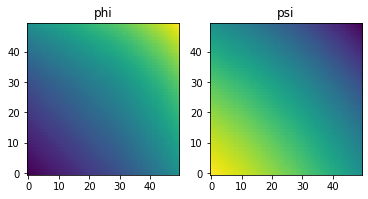

In [67]:
# from screening import compute_dx, compute_dy, c_transform_cpp, c_transform_forward_cpp , approx_push_cpp

import screening as sc
from IPython import display

# parameters
# grid size n x n
n = 50

# step size for the gradient ascent
L = 5000

# epsilon for pushforward
epsilon = 1e-2
max_iteration = 10000000

X, Y = np.meshgrid(np.linspace(0.5/n,1-0.5/n,n), np.linspace(0.5/n,1-0.5/n,n))

Xx = X + 1
Xy = Y + 1
yMax = 2.0
Yx = yMax * X
Yy = yMax * Y

dx = 1.0/n
dy = dx * yMax

# kernel = initialize_kernel(n, n, dy)
kernel = initialize_kernel(n, n, 1.0/n*yMax)

Xv = np.zeros((n*n,2))
Xv[:,0] = Xx.reshape((n*n,))
Xv[:,1] = Xy.reshape((n*n,))

Yv = np.zeros((n*n,2))
Yv[:,0] = Yx.reshape((n*n,))
Yv[:,1] = Yy.reshape((n*n,))

cost_np = - np.sum(Xv.reshape((n*n,1,2)) * Yv.reshape((1,n*n,2)),axis=2)
print("size of cost: ", cost_np.shape)
b    = 0.5 * (Yx**2 + Yy**2)
print("b:", b.shape, Yx.shape, Yy.shape)

psi_np = - 0.5*(Xx**2+Xy**2)
phi_np = np.zeros((n,n))
nu_np   = np.zeros((n,n))
sc.c_transform_forward_cpp(phi_np, psi_np, cost_np)


fig = plt.figure()
ax = fig.add_subplot(121)
ax.imshow(phi_np, origin="lower")
ax.set_title("phi")
ax = fig.add_subplot(122)
ax.imshow(psi_np, origin="lower")
ax.set_title("psi")
plt.show()

# phi  = torch.from_numpy(phi).type(torch.float32)
cost = torch.from_numpy(cost_np)
phi  = torch.from_numpy(phi_np)
psi  = torch.from_numpy(psi_np)
nu   = torch.from_numpy(nu_np)

# c_transform_forward(phi, psi, cost)

# fig = plt.figure()
# ax = fig.add_subplot(121)
# ax.imshow(phi, origin="lower")
# ax.set_title("phi")
# ax = fig.add_subplot(122)
# ax.imshow(psi, origin="lower")
# ax.set_title("psi")
# plt.show()


# fig,ax = plt.subplots(1,2,figsize=(10,5))

# sc.approx_push_cpp(nu_np, psi_np, phi_np, cost_np, epsilon, dx, dy, yMax)
# ax[0].imshow(nu_np, origin='lower')
# ax[0].set_title(f"sum: {np.sum(nu_np)*dy*dy}")
 
# approx_push(nu, psi, phi, cost, epsilon, dx, dy, yMax)
# ax[1].imshow(nu, origin='lower')
# ax[1].set_title(f"sum: {torch.sum(nu)*dy*dy}")
# plt.show()

u = np.zeros((n,n))

if cuda:
  phi  = phi.cuda()
  psi  = psi.cuda()
  cost = cost.cuda()
  nu   = nu.cuda()

# Graph structure

Suppose we have a graph $(Y,B)$ where $Y=\{x_i\}$ is the set containing $n$ points in $\mathbb{R}^d$ and $B$ is the set containing $m$ edges. We will make 4 arrays.

Denote by $i_Y$ the index of node and $j_B$ the index of edge.

Defining the incidence matrix $I \in \mathbb{R}^{|B|\times |Y|}$.

1. $I(a,y)$

n: 50 m: 19404
edge index:   0 node index:   0 target node:   1
edge index:   1 node index:   0 target node:  50
edge index:   2 node index:   0 target node:  51
edge index:   3 node index:   1 target node:   0
edge index:   4 node index:   1 target node:   2
edge index:   5 node index:   1 target node:  50
edge index:   6 node index:   1 target node:  51
edge index:   7 node index:   1 target node:  52
edge index:   8 node index:   2 target node:   1
edge index:   9 node index:   2 target node:   3
edge index:  10 node index:   2 target node:  51
Incidence matrix: (19404, 2500)
[[669 104  53]
 [670 104  54]
 [671 104  55]
 [672 104 103]
 [673 104 105]
 [674 104 153]
 [675 104 154]
 [676 104 155]]


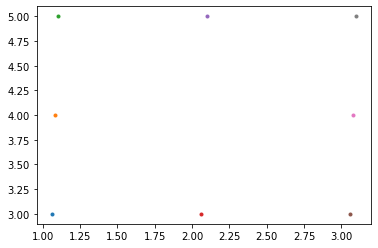

In [68]:
### Graph structure

def inside_domain(i,j,n):
    if i>=0 and i<n and j>=0 and j<n:
        return True
    return False
# counting m

## original
# def compute_m(n, st_n=1):
#     edges_info   = []
#     node2edge = []
#     node_ind = 0
#     edge_ind = 0
#     for i in range(n):
#         for j in range(n):
#             node2edge.append(edge_ind)

#             for ii in range(-st_n,st_n+1):
#                 for jj in range(-st_n,st_n+1):
#                     if i!=ii or j!=jj:
#                         if inside_domain(i+ii,j+jj,n):
#                             edges_info.append([edge_ind, node_ind,  (i+ii)*n+(j+jj)])
#                             edge_ind += 1    
#             node_ind += 1
#     node2edge.append(edge_ind)
#     return np.array(edges_info,dtype='int32'), np.array(node2edge,dtype='int32')

def compute_m(n, st_n=1):
    edges_info   = []
    node2edge = []
    node_ind = 0
    edge_ind = 0
    for i in range(n):
        for j in range(n):
            node2edge.append(edge_ind)

            for ii in range(-st_n,st_n+1):
                for jj in range(-st_n,st_n+1):
                    if 0!=ii or 0!=jj:
                        if inside_domain(i+ii,j+jj,n):
                            edges_info.append([edge_ind, node_ind,  (i+ii)*n+(j+jj)])
                            edge_ind += 1    
            node_ind += 1
    node2edge.append(edge_ind)
    return np.array(edges_info,dtype='int32'), np.array(node2edge,dtype='int32')

edges_info, node2edge = compute_m(n, 1) # the second argument: the size of the stencils
edge2target = edges_info[:,2]

m = edges_info.shape[0]
count = 0

print(f"n: {n} m: {m}")
for i,j,k in edges_info:
    print(f"edge index: {i:3d} node index: {j:3d} target node: {k:3d}" )
    count += 1
    if count > 10:
        break

### creating incidence matrix
# TODO: make this as a sparse matrix
Inc = np.zeros((m,n*n))
for i in range(m):
    edge_ind, node_ind, target_ind = edges_info[i]
    Inc[i, node_ind]   = -1
    Inc[i, target_ind] = 1

IncT = Inc.T

print(f"Incidence matrix: {Inc.shape}")
print(edges_info[node2edge[104]:node2edge[105]])

for _,_,k in edges_info[node2edge[104]:node2edge[105]]:
    i = k/n
    j = k%n
    plt.plot(i,j,'.')
plt.show()

## Filter the interior nodes and boundary nodes

In [82]:
node2edge

array([    0,     3,     8, ..., 19396, 19401, 19404], dtype=int32)

In [69]:
interior_nodes = []
boundary_nodes = []

stencil_size = 1
for k in range(n*n):
    i = k // n
    j = k %  n
    if i<stencil_size or i>=n-stencil_size or j<stencil_size or j>=n-stencil_size:
        boundary_nodes.append(k)
    else:
        interior_nodes.append(k)

## Sanity check for S_ind_np function

done


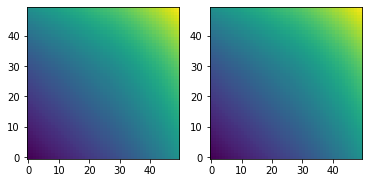

error: 0.0. Okay!


In [70]:
S_ind_np = np.zeros((n*n),dtype='int32')
sc.compute_Sy_cpp(S_ind_np,psi_np,cost_np)
psi_cost = psi_np.reshape((n*n))[S_ind_np] - cost_np[S_ind_np,np.arange(n*n)]
fig = plt.figure()
ax = fig.add_subplot(121)
ax.imshow(psi_cost.reshape((n,n)),origin='lower')
ax = fig.add_subplot(122)
ax.imshow(phi_np,origin='lower')
plt.show()
print(f"error: {np.sum((psi_cost - phi_np.reshape((n*n)))**2)/(n*n)}. Okay!")

## Creating a matrix $G_{ij}$

For example, if we consider the stencil of 4 neighboring points, the matrix would be of size $4\times 4$.

Each entry of the matrix is defined by
$$ G(y)(\eta',\eta'')=\delta_c(S(y),y,S(y''),y') = c(S(y),y')+c(S(y''),y)-c(S(y),y)-c(S(y''),y'). $$
where $\eta' = (y,y')$ and $\eta''=(y,y'')$ and
$$ S(y) = \argmax_{x} \psi(x) - c(x,y). $$

### ISSUE

It turns out that $S(y'') = S(y)$. Thus, what happens is
$$c(S(y),y')+c(S(y''),y)-c(S(y),y)-c(S(y''),y') = 0$$
This still happens even if I increase the size of the stencils.

Let's try the following:
$$\nabla \phi(y) = S(y)$$

In [72]:
def find_cost(cost, S_ind, y, yp, ypp):
    S_y   = S_ind[y]
    S_ypp = S_ind[ypp]
    if S_y != S_ypp:
        print(f"Sy: {S_y} S_ypp: {S_ypp} y: {y} yp: {yp}")
    return cost[S_y,yp] + cost[S_ypp,y] - cost[S_y,y] - cost[S_ypp,yp]

def compute_cost(x1,x2,y1,y2):
    return - x1*y1 - x2*y2
"""
    using the gradient instead of arg max.
"""
def find_cost2(cost, phi_np, S_ind, y, yp, ypp):
    dx = 1.0/n
    dy = dx * yMax
    i = y//n
    j = y%n
    y1 = (j+0.5)*dy
    y2 = (i+0.5)*dy
    S_y1  = (phi_np[i,j] - phi_np[i,int(max(0,j-1))])/dy
    S_y2  = (phi_np[i,j] - phi_np[int(max(0,i-1)),j])/dy
    
    i = ypp//n
    j = ypp%n
    S_ypp1  = (phi_np[i,j] - phi_np[i,int(max(0,j-1))])/dy
    S_ypp2  = (phi_np[i,j] - phi_np[int(max(0,i-1)),j])/dy

    i = yp//n
    j = yp%n
    yp1 = (j+0.5)*dy
    yp2 = (i+0.5)*dy
    # return cost[S_y,yp] + cost[S_ypp,y] - cost[S_y,y] - cost[S_ypp,yp]
    return compute_cost(S_y1,S_y2,yp1,yp2) + compute_cost(S_ypp1,S_ypp2,y1,y2) - compute_cost(S_y1,S_y2,y1,y2) - compute_cost(S_ypp1,S_ypp2,yp1,yp2)


""" Compute the G(y) matrix (size: # edges x # edges)"""
def compute_Gy(node_ind,edge2target):
    edge_start = node2edge[node_ind]
    edge_end   = node2edge[node_ind+1]
    edge_N = edge_end - edge_start
    out = np.zeros((edge_N,edge_N))
    for ind2 in range(edge_start,edge_end):
        target2 = edge2target[ind2]
        for ind1 in range(edge_start,edge_end):
            target1 = edge2target[ind1]
            # val = find_cost(cost_np, S_ind_np, node_ind, target1, target2)
            val = find_cost2(cost_np, phi_np, S_ind_np, node_ind, target1, target2)
            # print(node_ind,target1,target2,val)
            out[ind2-edge_start,ind1-edge_start] = val

    return out

node_ind=interior_nodes[3]
out = compute_Gy(node_ind,edge2target)
def print2d(out):
    ss =""
    for i in out:
        ss += "["
        for j in i:
            ss += f" {j:0.2e} "
        ss +="]\n"
    print(ss)
print2d(out)

[ 4.04e-02  4.04e-02  4.04e-02  0.00e+00  0.00e+00  -4.04e-02  -4.04e-02  -4.04e-02 ]
[ 4.04e-02  4.04e-02  4.04e-02  0.00e+00  0.00e+00  -4.04e-02  -4.04e-02  -4.04e-02 ]
[ 4.04e-02  4.04e-02  4.04e-02  0.00e+00  0.00e+00  -4.04e-02  -4.04e-02  -4.04e-02 ]
[ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 ]
[ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 ]
[ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 ]
[ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 ]
[ -2.22e-16  -1.39e-16  -2.78e-17  -1.11e-16  5.55e-17  0.00e+00  1.11e-16  2.22e-16 ]



In [88]:
def compute_H(cost_np, S_ind_np, edge2target, node2edge):
    H = np.zeros((m,m))

    for node in boundary_nodes:
        # print(f"node: {node}")
        # create a matrix coming from this node
        # the next 2 lines use cpp code
        # tmp_size = node2edge[node+1] - edge_ind # number of edges coming from this node
        # tmp_mat  = np.zeros((tmp_size, tmp_size)); sc.compute_Gy_cpp(tmp_mat, cost_np, phi_np, S_ind_np, edge2target, node2edge,dy,node) # this will initialize the tmp_matrix
        
        edge_ind = node2edge[node]
        tmp_mat = compute_Gy(node,edge2target)
        tmp_mat[np.arange(tmp_mat.shape[0]),np.arange(tmp_mat.shape[0])] += 1e-5
        tmp_mat = np.linalg.inv(tmp_mat) # inverting the matrix
        H[edge_ind:node2edge[node+1],edge_ind:node2edge[node+1]] = tmp_mat
    return H

H = compute_H(cost_np, S_ind_np, edge2target, node2edge)
print(H)

[[ 33347.08153235  33322.33518244 -33330.5832852  ...      0.
       0.              0.        ]
 [ 33322.33518244  33347.08153235 -33330.5832852  ...      0.
       0.              0.        ]
 [-33330.5832852  -33330.5832852   33338.83342958 ...      0.
       0.              0.        ]
 ...
 [     0.              0.              0.         ...  33471.93346896
  -33264.03326108 -33264.03326108]
 [     0.              0.              0.         ... -33264.03326106
   33678.54237124  33057.42435882]
 [     0.              0.              0.         ... -33264.03326106
   33057.42435882  33678.54237124]]


''

NameError: name 'c_transform_cpp' is not defined

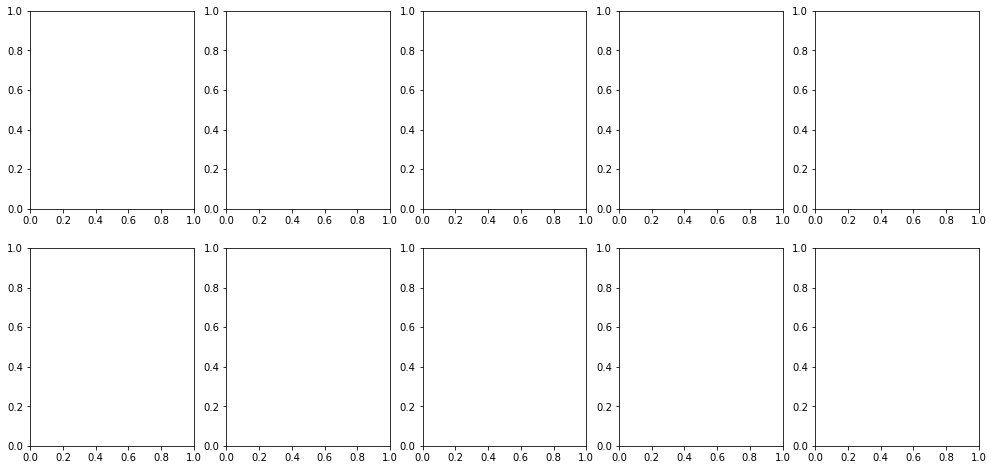

In [28]:
fig,ax = plt.subplots(2,5,figsize=(17,8))
hdisplay = display.display("", display_id=True)

for it in range(max_iteration):
  # c_transform(psi, phi, cost)
  c_transform_cpp(psi_np, phi_np, cost_np)

  # print(f"min: {torch.min(psi.view((n*n,1)) - phi.view((1,n*n)) - cost)} max: {torch.max(psi.view((n*n,1)) - phi.view((1,n*n)) - cost)}")

  # pushforward mu -> nu
  approx_push(nu, psi, phi, cost, epsilon, dx, dy, yMax)

  # calculate rho
  compute_rho()

  compute_D()

  # gradient ascent
  error   = np.mean(u**2)/L**2
  phi_np += 1.0/L * u

  # if error > 1e3:
  #   print("wrong values")
  #   break

  if it % 10 == 0:
    ax[0,0].imshow(nu_np,origin='lower')
    ax[0,0].set_title("nu")
    ax[0,1].imshow(phi_np,origin='lower')
    ax[0,1].set_title("phi")
    ax[0,2].imshow(psi_np,origin='lower')
    ax[0,2].set_title("psi")
    ax[0,3].imshow(rhs,origin='lower')
    ax[0,3].set_title("rhs")
    ax[0,4].imshow(u,origin='lower')
    ax[0,4].set_title("u")

    ax[1,0].imshow(R1,origin='lower')
    ax[1,0].set_title("R1")
    ax[1,1].imshow(R2,origin='lower')
    ax[1,1].set_title("R2")
    ax[1,2].imshow(R1x,origin='lower')
    ax[1,2].set_title("R1x")
    ax[1,3].imshow(R2y,origin='lower')
    ax[1,3].set_title("R2y")
    
    fx = np.zeros((n, n))
    phi_b = phi_np-b
    compute_dx(fx, phi_b, dy)
    ax[1,4].imshow(fx,origin='lower')
    ax[1,4].set_title("partial_i phi-b")
    plt.suptitle(f"it={it} error={error:0.2e}")
    plt.savefig(f"images/{it//10:03d}.png")
    # plt.show()
    hdisplay.update(fig)


    # fix,ax = plt.subplots(1,1)
    # A=psi.view((1,n*n)) - phi.view((n*n,1)) - cost
    # A = A.detach().cpu().numpy()
    # ax.imshow(A)
    # ax.set_title(f"{np.max(A)} {np.min(A)}")
    # plt.show()

  # phi  = torch.from_numpy(phi_np).type(torch.float32)
  # if cuda:
  #   phi = phi.cuda()

In [ ]:
import glob
import cv2

img_array = []
for filename in glob.glob('./images/*.png'):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)


out = cv2.VideoWriter('project.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)

for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

from IPython.display import Video
Video("project.mp4")

In [ ]:
!rm images/*
